In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_fft_cnn import PPO_make_train as PPO_FFT_make_train
from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train
from rl_algos.ppo_continuous import PPO_make_train as PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

## Training Standard PPO with Smoothing + Bandwidth Transfer wo Smoothing or Bandwidth Reward

In [5]:
# Defining Cairo Params and RL Params

# Static Physics Params
tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0
shot_noise_std = 0.01
standard_fid = 0.99

time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 0.0
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = True
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.
apply_bandwidth_constraint = True

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    # "KERNEL_SIZE": 15,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [6]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: 14.134
max pF: 2.508
max photon: 28.635
photon time: 0.7841
smoothness: 0.000237
bandwidth: 45.480000000000004
global update: 200
reward: 16.016000000000002
max pF: 2.498
max photon: 29.818
photon time: 0.5094000000000001
smoothness: 0.000272
bandwidth: 44.969
global update: 300
reward: 18.043
max pF: 2.531
max photon: 32.730000000000004
photon time: 0.332
smoothness: 0.000327
bandwidth: 45.465
global update: 400
reward: 18.979
max pF: 2.547
max photon: 35.394
photon time: 0.316
smoothness: 0.000376
bandwidth: 45.651
global update: 500
reward: 19.563
max pF: 2.553
max photon: 36.478
photon time: 0.2954
smoothness: 0.000421
bandwidth: 46.023
global update: 600
reward: 20.329
max pF: 2.555
max photon: 36.871
photon time: 0.2859
smoothness: 0.000463
bandwidth: 46.921
global update: 700
reward: 20.868000000000002
max pF: 2.5580000000000003
max photon: 36.713
photon time: 0.2766
smoothness: 0.00042699999999999997
bandwidth: 46.472
gl

In [7]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

In [8]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]

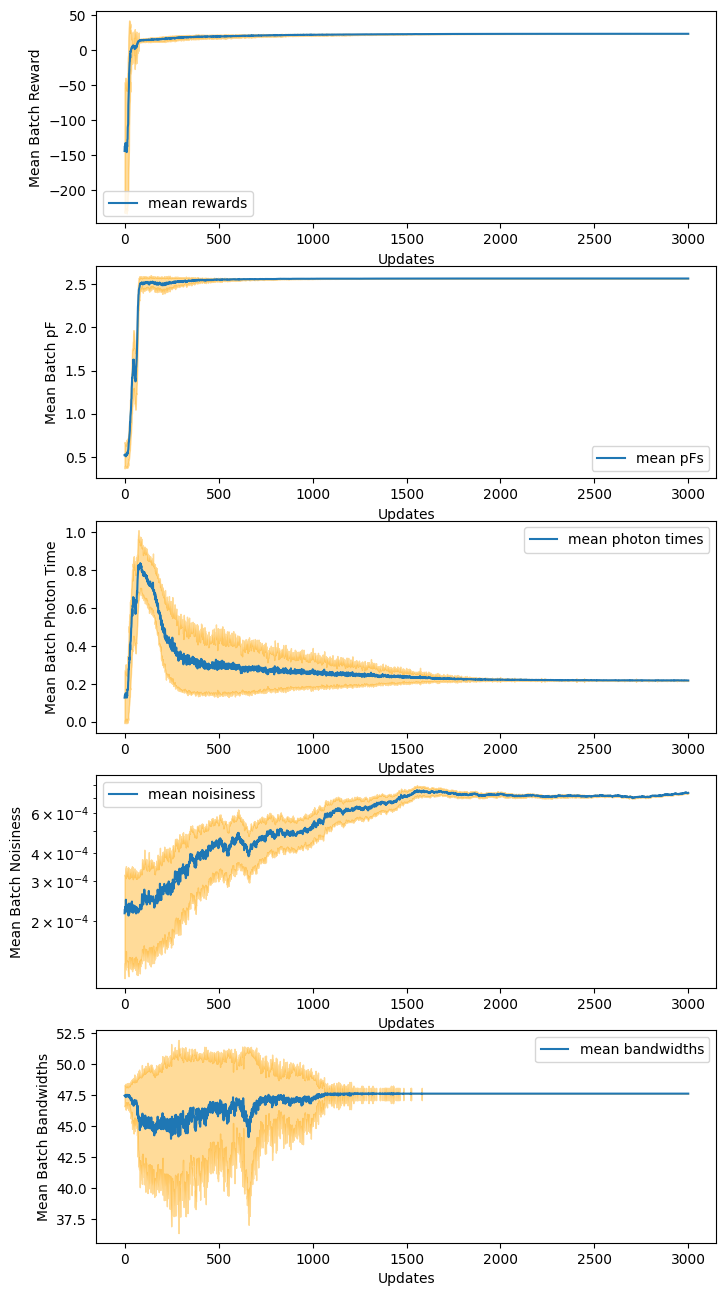

In [9]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

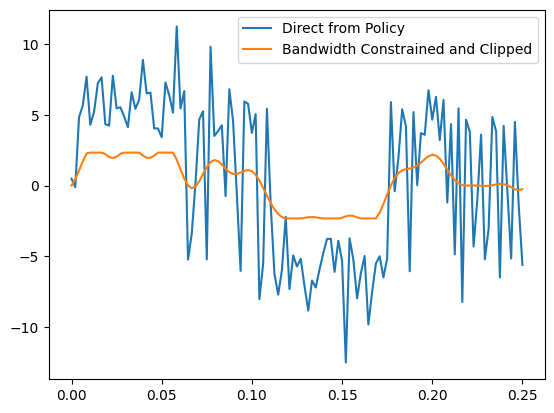

In [16]:
raw_final_action = -jnp.mean(actions, axis=1)[-1]
raw_final_action = -actions[-1, 0]
raw_transformed_action = env.prepare_action(raw_final_action)
env.kernel = env.default_params.gauss_kernel
smooth_final_action = env.drive_smoother(raw_transformed_action)

plt.plot(env.ts_action, raw_final_action, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()

Here the learned pulse looks roughly like what we want, but the bandwidth is exactly limited by the waveform transformation, and is too high. Maybe we can try reducing the bandwidth in the transformer for even smoother pulses?

## Applying Lower Bandwidth Transformation for smoother result

In [17]:
config_2 = config
config_2["ENV_PARAMS"]["bandwidth"] = 20. # Changing Bandwidth from 50MHz to 20MHz

single_train_2 = jit(PPO_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: 14.558
max pF: 2.5060000000000002
max photon: 28.26
photon time: 0.8141
smoothness: 9.999999999999999e-06
bandwidth: 19.37
global update: 200
reward: 15.875
max pF: 2.501
max photon: 30.861
photon time: 0.6195
smoothness: 1.4e-05
bandwidth: 19.602
global update: 300
reward: 17.576
max pF: 2.503
max photon: 33.335
photon time: 0.3758
smoothness: 2.3e-05
bandwidth: 19.571
global update: 400
reward: 18.449
max pF: 2.505
max photon: 34.882
photon time: 0.33140000000000003
smoothness: 4.7e-05
bandwidth: 19.835
global update: 500
reward: 19.255
max pF: 2.512
max photon: 35.361000000000004
photon time: 0.2999
smoothness: 5.4999999999999995e-05
bandwidth: 19.835
global update: 600
reward: 20.086000000000002
max pF: 2.5220000000000002
max photon: 36.405
photon time: 0.2797
smoothness: 5.8e-05
bandwidth: 19.835
global update: 700
reward: 20.284
max pF: 2.5220000000000002
max photon: 36.872
photon time: 0.3039
smoothness: 6.599999999999999

In [18]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
bandwidths_2 = metrics_2["bandwidth"]
actions_2 = metrics_2["action"]

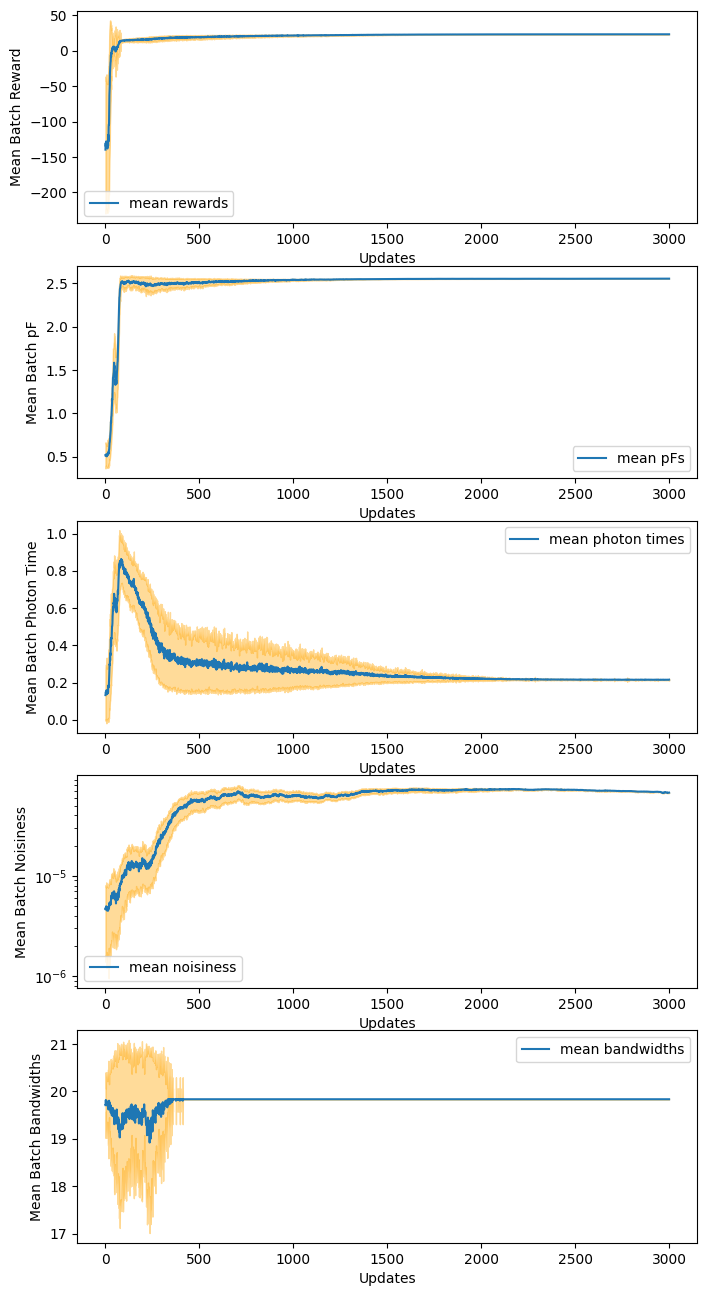

In [19]:
plot_learning(
    rewards=rewards_2,
    max_pFs=max_pFs_2,
    photon_times=photon_times_2,
    smoothnesses=smoothnesses_2,
    bandwidths=bandwidths_2,
)

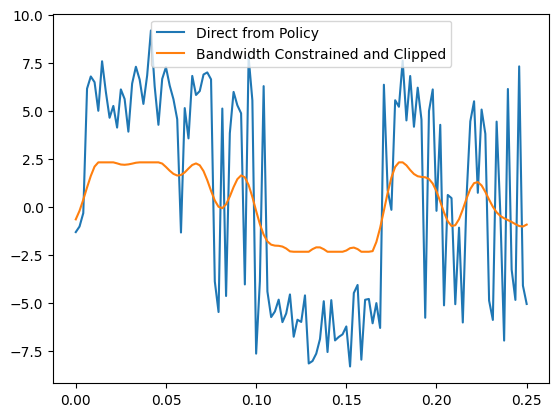

In [20]:
raw_final_action_2 = -jnp.mean(actions_2, axis=1)[-1]
# raw_final_action_2 = -actions_2[-1, 0]
raw_transformed_action_2 = env.prepare_action(raw_final_action_2)
env.kernel = env.default_params.gauss_kernel
smooth_final_action_2 = env.drive_smoother(raw_transformed_action_2)

plt.plot(env.ts_action, raw_final_action_2, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action_2 / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()

The waveform is quite similar to the previous one, but now the bandwidth is even lower! However the NN output is too large, to reduce this we can try using a clipped gaussian distribution for the PPO policy.

## Using PPO with a Clipped Gaussian Distribution Policy

In [21]:
single_train_3 = jit(PPO_Clipped_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_3 = single_train_3(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: 14.625
max pF: 2.505
max photon: 28.112000000000002
photon time: 0.8017000000000001
smoothness: 9.999999999999999e-06
bandwidth: 19.37
global update: 200
reward: 15.99
max pF: 2.497
max photon: 30.362000000000002
photon time: 0.6121
smoothness: 1.4e-05
bandwidth: 19.587
global update: 300
reward: 17.854
max pF: 2.505
max photon: 33.437
photon time: 0.37260000000000004
smoothness: 2.8e-05
bandwidth: 19.649
global update: 400
reward: 18.79
max pF: 2.511
max photon: 35.082
photon time: 0.3244
smoothness: 4.9999999999999996e-05
bandwidth: 19.835
global update: 500
reward: 19.6
max pF: 2.513
max photon: 35.414
photon time: 0.28800000000000003
smoothness: 5.6999999999999996e-05
bandwidth: 19.835
global update: 600
reward: 20.322
max pF: 2.521
max photon: 36.475
photon time: 0.2721
smoothness: 5.9e-05
bandwidth: 19.835
global update: 700
reward: 20.443
max pF: 2.527
max photon: 36.924
photon time: 0.28800000000000003
smoothness: 6.5999

In [22]:
# Extracting Results

metrics_3 = single_result_3["metrics"]

rewards_3 = metrics_3["reward"]
max_pFs_3 = metrics_3["max pF"]
max_photons_3 = metrics_3["max photon"]
photon_times_3 = metrics_3["photon time"]
smoothnesses_3 = metrics_3["smoothness"]
bandwidths_3 = metrics_3["bandwidth"]
actions_3 = metrics_3["action"]

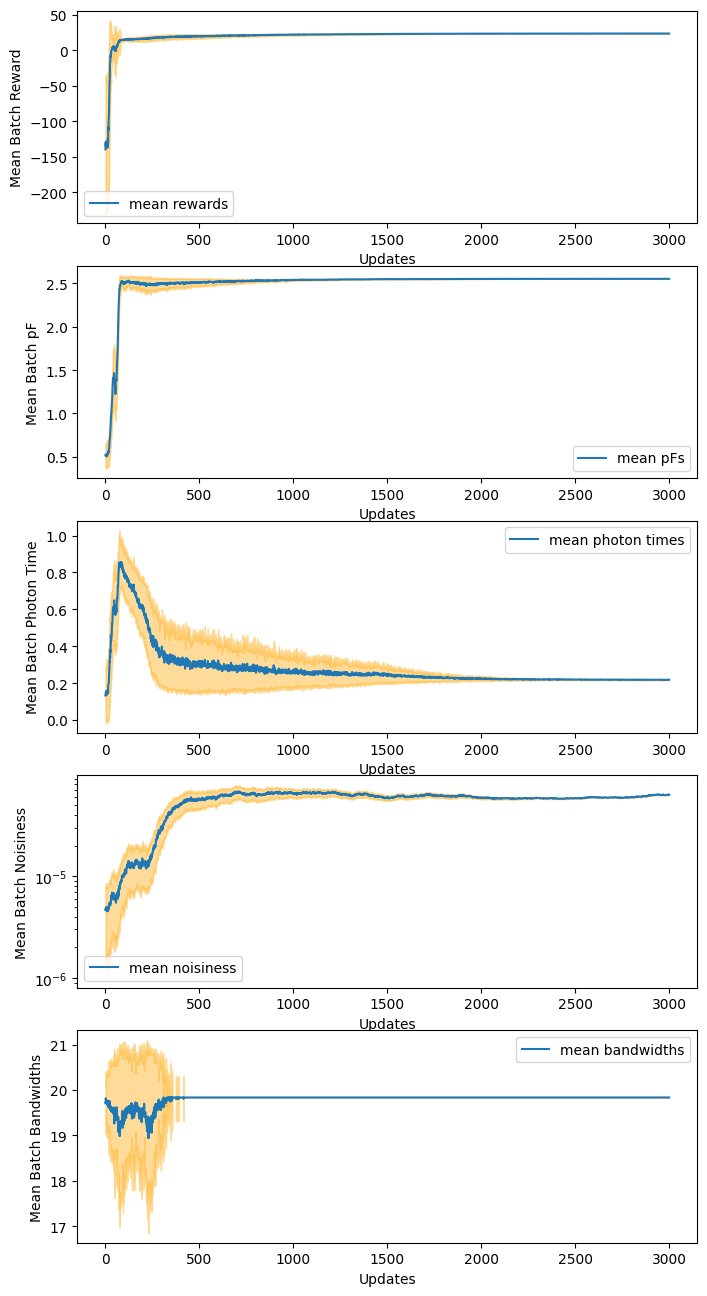

In [23]:
plot_learning(
    rewards=rewards_3,
    max_pFs=max_pFs_3,
    photon_times=photon_times_3,
    smoothnesses=smoothnesses_3,
    bandwidths=bandwidths_3,
)

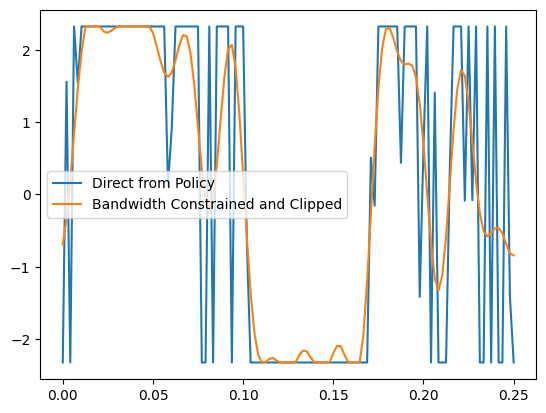

In [24]:
raw_final_action_3 = -jnp.mean(actions_3, axis=1)[-1]
# raw_final_action_2 = -actions_2[-1, 0]
raw_transformed_action_3 = env.prepare_action(raw_final_action_3)
env.kernel = env.default_params.gauss_kernel
smooth_final_action_3 = env.drive_smoother(raw_transformed_action_3)

plt.plot(env.ts_action, raw_final_action_3, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action_3 / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()

Now the NN Output matches the scale of our waveforms! The learned waveform is still the same (compare the orange waveform here with the previous waveforms), but from this perspective the Neural Network is outputting far too noisy signals, and the Readout Waveform also has too many mini-features for our preference. Lets try reducing the bandwidth frequency even further!

In [26]:
config_4 = config
config_4["ENV_PARAMS"]["bandwidth"] = 10.

single_train_4 = jit(PPO_Clipped_make_train(config_4), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_4 = single_train_4(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: 12.388
max pF: 2.482
max photon: 27.76
photon time: 0.8787
smoothness: 0.0
bandwidth: 7.779
global update: 200
reward: 14.911
max pF: 2.47
max photon: 35.167
photon time: 0.6989000000000001
smoothness: 2e-06
bandwidth: 7.934
global update: 300
reward: 17.094
max pF: 2.449
max photon: 37.346000000000004
photon time: 0.3704
smoothness: 4.9999999999999996e-06
bandwidth: 7.934
global update: 400
reward: 17.397000000000002
max pF: 2.461
max photon: 38.792
photon time: 0.3396
smoothness: 7e-06
bandwidth: 7.934
global update: 500
reward: 18.021
max pF: 2.458
max photon: 38.537
photon time: 0.3375
smoothness: 7e-06
bandwidth: 7.934
global update: 600
reward: 18.61
max pF: 2.467
max photon: 38.872
photon time: 0.32330000000000003
smoothness: 7e-06
bandwidth: 7.934
global update: 700
reward: 18.941
max pF: 2.476
max photon: 39.362
photon time: 0.33
smoothness: 8e-06
bandwidth: 7.934
global update: 800
reward: 19.057000000000002
max pF: 2.

In [27]:
# Extracting Results

metrics_4 = single_result_4["metrics"]

rewards_4 = metrics_4["reward"]
max_pFs_4 = metrics_4["max pF"]
max_photons_4 = metrics_4["max photon"]
photon_times_4 = metrics_4["photon time"]
smoothnesses_4 = metrics_4["smoothness"]
bandwidths_4 = metrics_4["bandwidth"]
actions_4 = metrics_4["action"]

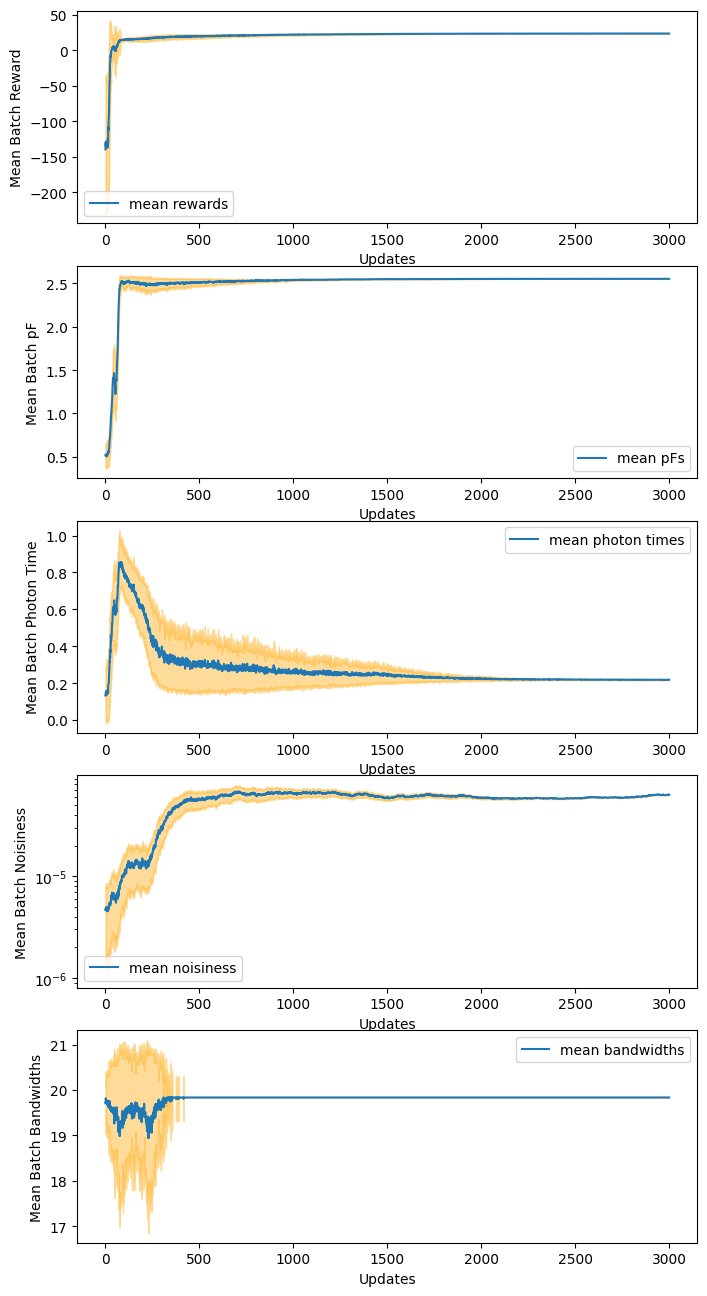

In [28]:
plot_learning(
    rewards=rewards_3,
    max_pFs=max_pFs_3,
    photon_times=photon_times_3,
    smoothnesses=smoothnesses_3,
    bandwidths=bandwidths_3,
)

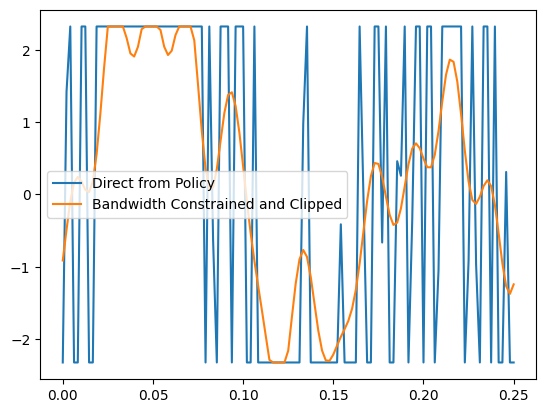

In [29]:
raw_final_action_4 = -jnp.mean(actions_4, axis=1)[-1]
# raw_final_action_2 = -actions_2[-1, 0]
raw_transformed_action_4 = env.prepare_action(raw_final_action_4)
env.kernel = env.default_params.gauss_kernel
smooth_final_action_4 = env.drive_smoother(raw_transformed_action_4)

plt.plot(env.ts_action, raw_final_action_4, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action_4 / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()

Seems like we technically find a waveform, but its getting too messy to make sense of. More precisely, it doesn't seem very robust. Lets try examining the robustness of the waveform using a stability test.

## Stability Tests

In [31]:
import copy

import chex

def waveform_kappa_chi_stability_tester(
    key: chex.PRNGKey,
    waveform: chex.PRNGKey,
    env_name: str,
    main_env_config: dict,
    error_percentage: Optional[float] = 10.0,
    num_vals: Optional[int] = 5,
):
    reduced_config = copy.deepcopy(main_env_config)
    kappa = reduced_config.pop("kappa")
    chi = reduced_config.pop("chi")

    env_class = photon_env_dicts()[env_name]

    def env_tester(key: chex.PRNGKey, kappa: float, chi: float):
        env = env_class(kappa=kappa, chi=chi, **reduced_config)
        env.shot_noise_std = 0.

        rng, _rng = jax.random.split(key)
        params = env.default_params
        init_obs, init_state = env.reset(_rng, params)

        rng, _rng = jax.random.split(rng)
        obs, state, reward, done, info = env.step(_rng, init_state, waveform, params)

        max_pF = state.max_pf
        max_photon = state.max_photon
        photon_time = state.photon_time

        return max_pF, max_photon, photon_time

    jitted_tester = jax.jit(jax.vmap(env_tester))

    error_val = error_percentage / 100.0
    kappas = jnp.linspace(kappa * (1. - error_val), kappa * (1. + error_val), num_vals)
    chis = jnp.linspace(chi * (1. - error_val), chi * (1. + error_val), num_vals)

    kappa_chi_grid = jnp.array(jnp.meshgrid(kappas, chis)).reshape(2, -1).T
    kappa_grid = kappa_chi_grid[:, 0]
    chi_grid = kappa_chi_grid[:, 1]

    rng, _rng = jax.random.split(key)
    rng_tester = jax.random.split(_rng, kappa_chi_grid.shape[0])

    res_pF, res_photon, res_photon_time = jitted_tester(
        rng_tester, kappa_grid, chi_grid
    )

    res_pF = res_pF.reshape(num_vals, -1)
    res_photon = res_photon.reshape(num_vals, -1)
    res_photon_time = res_photon_time.reshape(num_vals, -1)
    return res_pF, res_photon, res_photon_time, kappa_chi_grid, kappas, chis

In [32]:
error_percentage = 10.0
num_vals = 9 
# So overall it will test the performance of the waveform with deviations in kappa and chi of ±2.5, 5, 7.5, and 10%

stability_pF, stability_max_photon, stability_time, kappa_chi_grid, k_grid, c_grid = waveform_kappa_chi_stability_tester(
    _rng, 
    waveform=raw_final_action_2, # Testing out the Smooth Action from a 20MHz Bandwidth
    env_name=config_2["ENV_NAME"],
    main_env_config=env_config,
    error_percentage=error_percentage,
    num_vals=9
)

Fidelity Heat Map
Fidelity Mean: 0.9969302668683664, StdDev: 0.0006042364501568383
Fidelity Min: 0.9946016672431838, Max: 0.9975820155678643


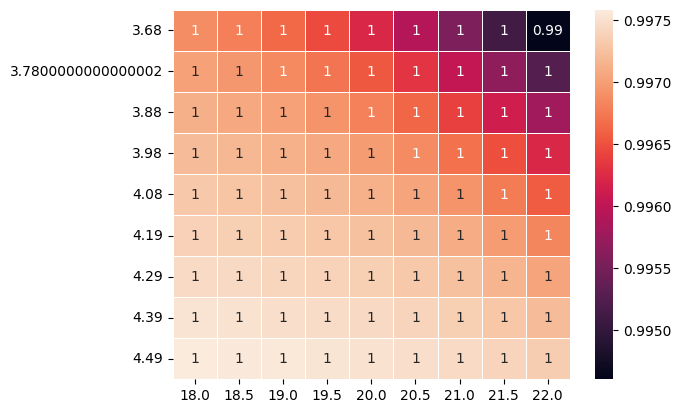

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

pf_data = stability_pF
fid_data = 1 - 10**(-pf_data)
photon_time_data = stability_time

k_grid = jnp.round(k_grid, 2)
c_grid = jnp.round(c_grid, 2)

fid_flat = fid_data.flatten()

print(f"Fidelity Heat Map")
print(f"Fidelity Mean: {jnp.mean(fid_flat)}, StdDev: {jnp.std(fid_flat)}")
print(f"Fidelity Min: {jnp.min(fid_flat)}, Max: {jnp.max(fid_flat)}")

ax1 = sns.heatmap(fid_data, linewidth=0.5, annot=True, xticklabels=k_grid, yticklabels=c_grid)

plt.show()

Photon Time Heat Map
Photon Time Mean: 0.2346236283327475, StdDev: 0.01615952661492549
Photon Time Min: 0.2086671249289793, Max: 0.2700575821376446
Maximum Percentage Change in Photon Time: 18.630796344539764


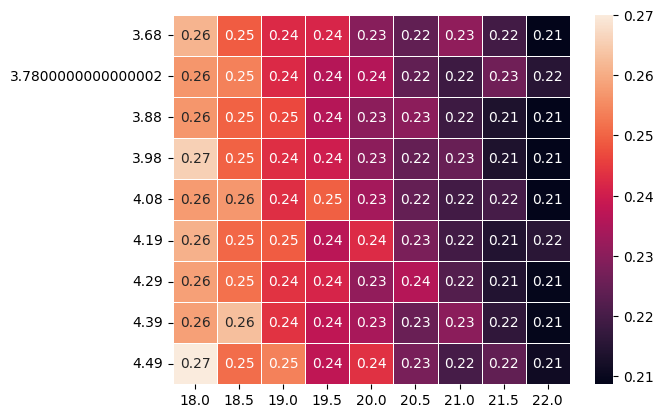

In [34]:
ax2 = sns.heatmap(photon_time_data, linewidth=0.5, annot=True, xticklabels=k_grid, yticklabels=c_grid)

photon_time_center = photon_time_data[num_vals // 2 + 1, num_vals // 2 + 1]
photon_time_flat = photon_time_data.flatten()

print(f"Photon Time Heat Map")
print(f"Photon Time Mean: {jnp.mean(photon_time_flat)}, StdDev: {jnp.std(photon_time_flat)}")
print(f"Photon Time Min: {jnp.min(photon_time_flat)}, Max: {jnp.max(photon_time_flat)}")
print(f"Maximum Percentage Change in Photon Time: {100. * jnp.max(jnp.abs(photon_time_flat - photon_time_center)) / photon_time_center}")

plt.show()

Photon Time Heat Map
Photon Time Mean: 45.30703598775981, StdDev: 0.32587623477838934
Photon Time Min: 44.700050354003906, Max: 46.13941192626953


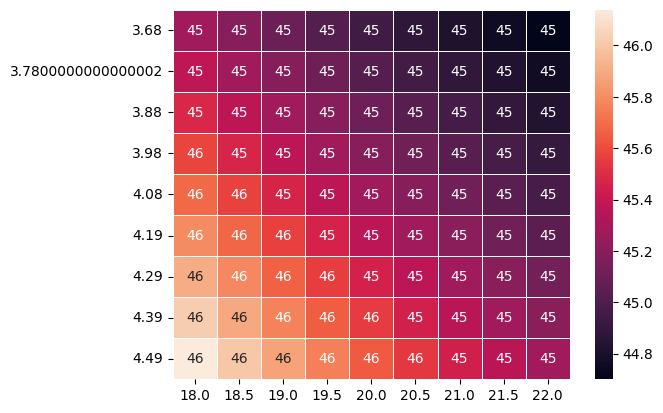

In [35]:
ax3 = sns.heatmap(stability_max_photon, linewidth=0.5, annot=True, xticklabels=k_grid, yticklabels=c_grid)

print(f"Photon Time Heat Map")
print(f"Photon Time Mean: {jnp.mean(stability_max_photon.flatten())}, StdDev: {jnp.std(stability_max_photon.flatten())}")
print(f"Photon Time Min: {jnp.min(stability_max_photon.flatten())}, Max: {jnp.max(stability_max_photon.flatten())}")

plt.show()

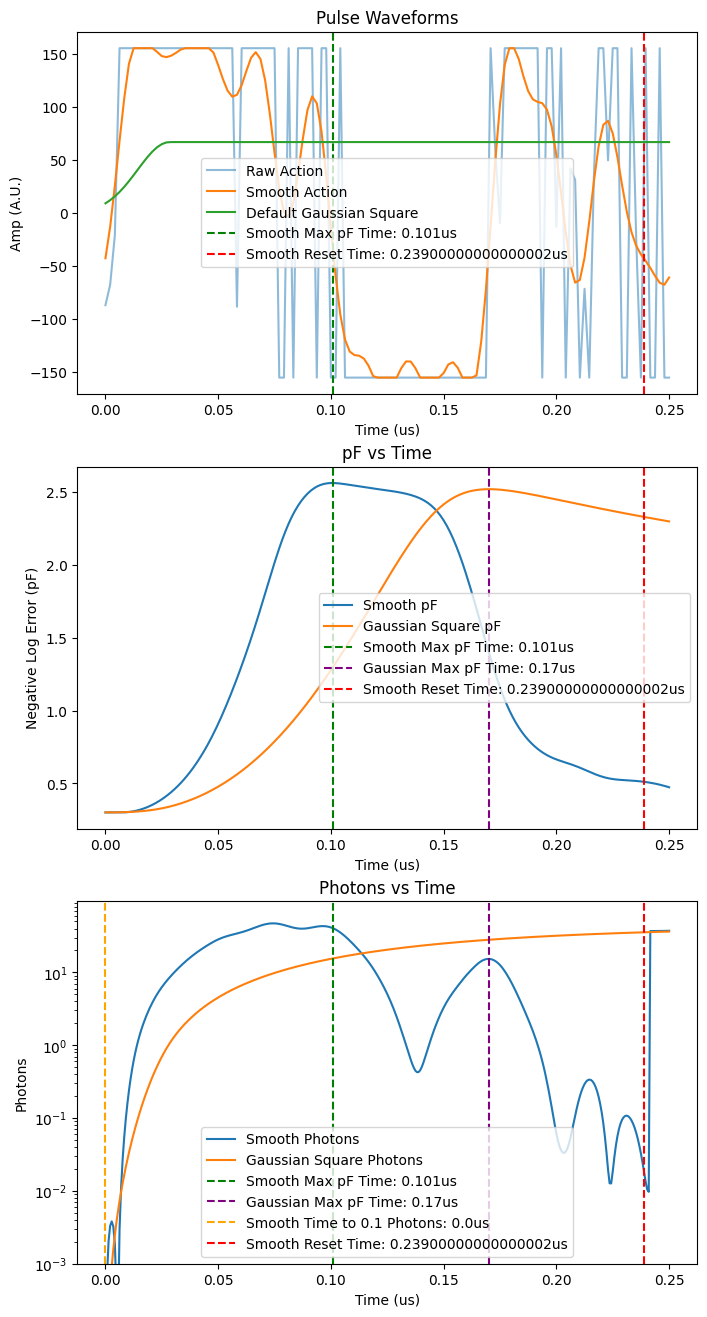

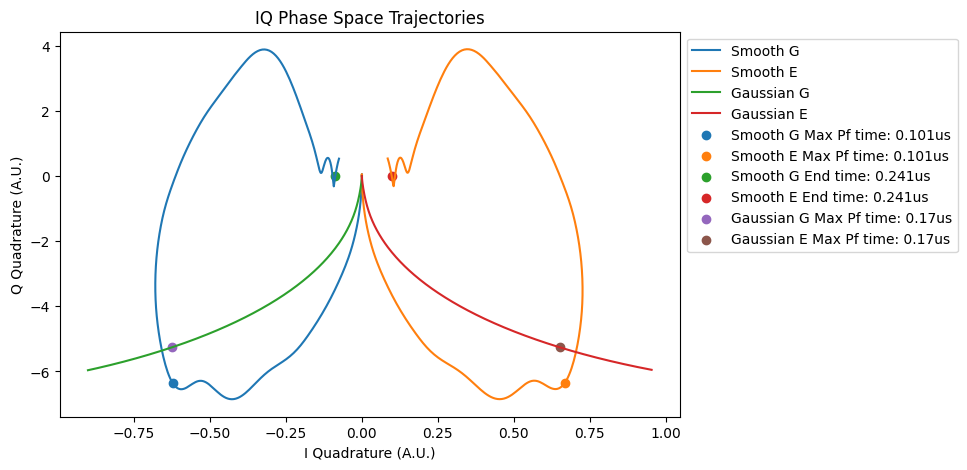

In [37]:
env.shot_noise_std = 0.
env.rollout_action(_rng, raw_final_action_2, photon_log_scale=True)

## Now Testing out with Smoothness in Reward Function and Transformer without Bandwidth in Transformer (Previous Reference of Learning)

In [42]:
config_5 = config
num_updates_2 = 5000
config_5["ENV_PARAMS"]["smoothness_coeff"] = 10.0 # Adding Original Smoothness Coeff
config_5["ENV_PARAMS"]["apply_smoothing"] = True # Applying Smoothing in Transformer
config_5["ENV_PARAMS"]["bandwidth"] = 250. # Removing Bandwidth Constraint
config_5["ENV_PARAMS"]["bandwidth_coeff"] = 0. # Removing Bandwidth Constraint
config_5["ENV_PARAMS"]["use_processed_action"] = True # Use Transformed Action for Calc
config_5["ENV_PARAMS"]["apply_bandwidth_constraint"] = False
config_5["NUM_UPDATES"] = num_updates_2

single_train_5 = jit(PPO_make_train(config_5), static_argnums=-1) # Using Standard PPO

print(f"Starting a Run of {num_updates_2} Updates")
start = time.time()
single_result_5 = single_train_5(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -188.257
max pF: 2.431
max photon: 26.616
photon time: 0.7481
smoothness: 0.0050149999999999995
bandwidth: 90.186
global update: 200
reward: -149.847
max pF: 2.559
max photon: 40.907000000000004
photon time: 0.8280000000000001
smoothness: 0.004062
bandwidth: 69.143
global update: 300
reward: -118.007
max pF: 2.5580000000000003
max photon: 40.423
photon time: 0.7858
smoothness: 0.003332
bandwidth: 56.25
global update: 400
reward: -80.96300000000001
max pF: 2.561
max photon: 40.353
photon time: 0.7522000000000001
smoothness: 0.002486
bandwidth: 44.132
global update: 500
reward: -49.81
max pF: 2.561
max photon: 40.091
photon time: 0.734
smoothness: 0.001762
bandwidth: 33.58
global update: 600
reward: -28.881
max pF: 2.562
max photon: 40.24
photon time: 0.6846
smoothness: 0.0012959999999999998
bandwidth: 29.923000000000002
global update: 700
reward: -16.336000000000002
max pF: 2.561
max photon: 39.995
photon time: 0.6243000000000001

In [43]:
# Extracting Results

metrics_5 = single_result_5["metrics"]

rewards_5 = metrics_5["reward"]
max_pFs_5 = metrics_5["max pF"]
max_photons_5 = metrics_5["max photon"]
photon_times_5 = metrics_5["photon time"]
smoothnesses_5 = metrics_5["smoothness"]
bandwidths_5 = metrics_5["bandwidth"]
actions_5 = metrics_5["action"]

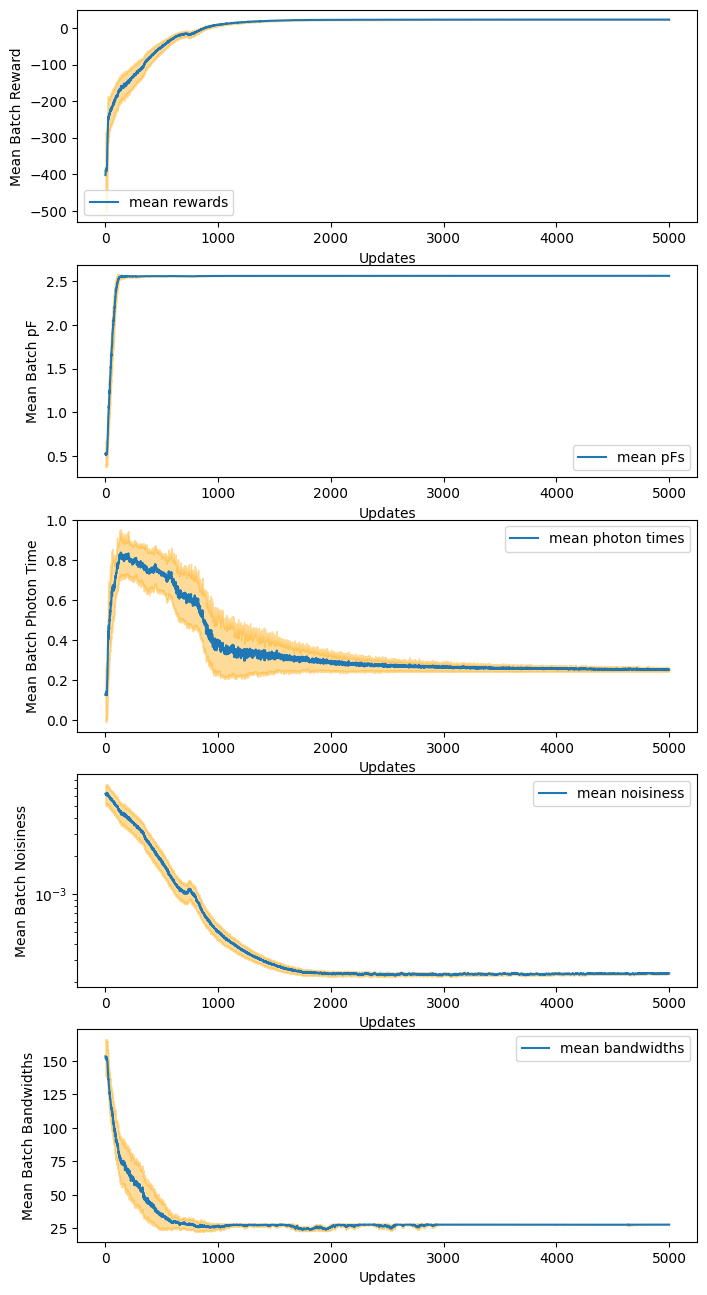

In [44]:
plot_learning(
    rewards=rewards_5,
    max_pFs=max_pFs_5,
    photon_times=photon_times_5,
    smoothnesses=smoothnesses_5,
    bandwidths=bandwidths_5,
)

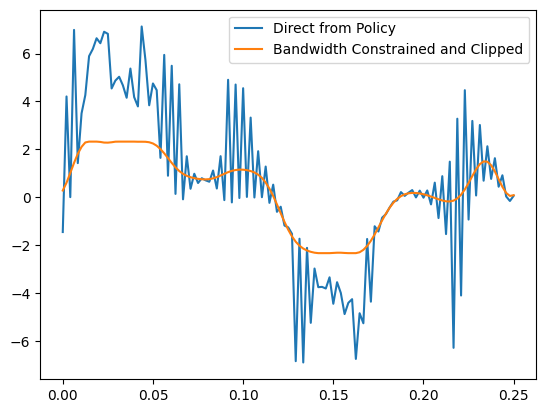

In [45]:
raw_final_action_5 = -jnp.mean(actions_5, axis=1)[-1]
# raw_final_action_2 = -actions_2[-1, 0]
raw_transformed_action_5 = env.prepare_action(raw_final_action_5)
env.kernel = env.default_params.gauss_kernel
smooth_final_action_5 = env.drive_smoother(raw_transformed_action_5)

plt.plot(env.ts_action, raw_final_action_5, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action_5 / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()

Looking at the Fourier Transform we can see the Significant Bandwidth Reduction achieved simply by the Gaussian Smoothing out of the high frequency components

Bandwidth wo Smoothing: 226.11570247933884MHz
Bandwidth w Smoothing: 47.60330578512397MHz


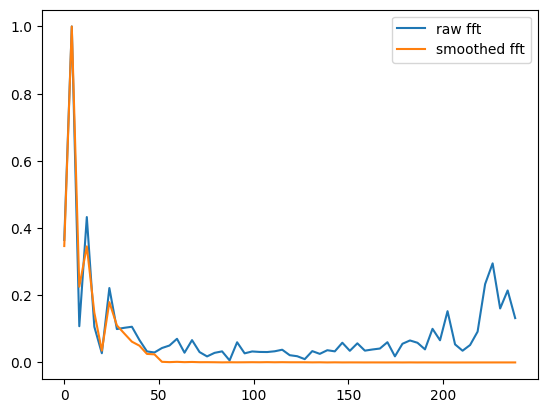

In [46]:
raw_bandwidth = env.calculate_bandwidth(raw_final_action_3 * env.a0)
smooth_bandwidth = env.calculate_bandwidth(raw_transformed_action_3)
print(f"Bandwidth wo Smoothing: {raw_bandwidth}MHz")
print(f"Bandwidth w Smoothing: {smooth_bandwidth}MHz")

from jax.numpy.fft import rfft, rfftfreq, irfft

r_freq = rfftfreq(n=len(raw_final_action_5), d=env.ts_action[1] - env.ts_action[0])
r_fft = jnp.abs(rfft(raw_final_action_5))
smooth_fft = jnp.abs(rfft(raw_transformed_action_5))

plt.plot(r_freq, r_fft / jnp.max(r_fft), label='raw fft')
plt.plot(r_freq, smooth_fft / jnp.max(smooth_fft), label='smoothed fft')
plt.legend()
plt.show()

And now comparing the stability performance

In [47]:
error_percentage = 10.0
num_vals = 9

stability_pF_5, stability_max_photon_5, stability_time_5, kappa_chi_grid_5, k_grid_5, c_grid_5 = waveform_kappa_chi_stability_tester(
    _rng, 
    waveform=raw_final_action_5, 
    env_name=config_5["ENV_NAME"],
    main_env_config=env_config,
    error_percentage=error_percentage,
    num_vals=9
)

Fidelity Heat Map
Fidelity Mean: 0.9972533767747656, StdDev: 0.00023320281266817826
Fidelity Min: 0.9967308941761707, Max: 0.9976484419892807


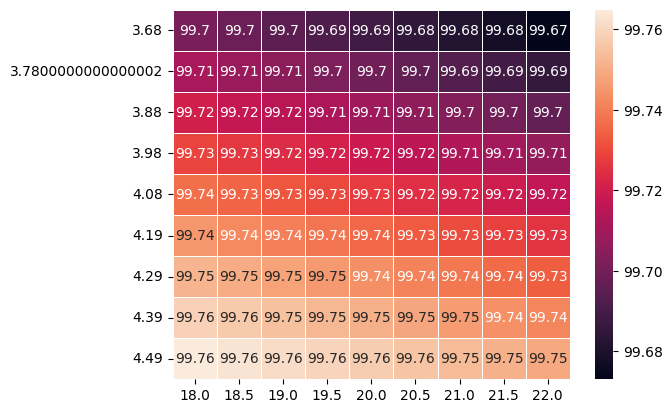

In [56]:
pf_data_5 = stability_pF_5
fid_data_5 = 1 - 10**(-pf_data_5)
photon_time_data_5 = stability_time_5

k_grid_5 = jnp.round(k_grid_5, 2)
c_grid_5 = jnp.round(c_grid_5, 2)

fid_flat_5 = fid_data_5.flatten()

print(f"Fidelity Heat Map")
print(f"Fidelity Mean: {jnp.mean(fid_flat_5)}, StdDev: {jnp.std(fid_flat_5)}")
print(f"Fidelity Min: {jnp.min(fid_flat_5)}, Max: {jnp.max(fid_flat_5)}")

ax1 = sns.heatmap(fid_data_5 * 100., linewidth=0.5, annot=True, fmt='.4', xticklabels=k_grid_5, yticklabels=c_grid_5)

plt.show()

Photon Time Heat Map
Photon Time Mean: 0.2584534041918271, StdDev: 0.03156975333588412
Photon Time Min: 0.22000000000000003, Max: 0.350527245704754
Maximum Percentage Change in Photon Time: 45.97884280238613


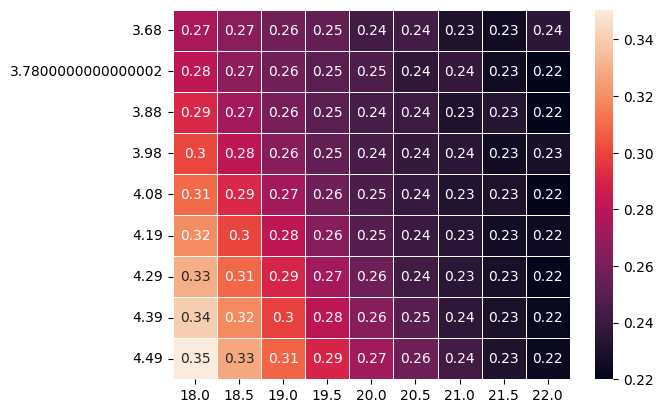

In [57]:
ax2 = sns.heatmap(photon_time_data_5, linewidth=0.5, annot=True, xticklabels=k_grid_5, yticklabels=c_grid_5)

photon_time_center_5 = photon_time_data_5[num_vals // 2 + 1, num_vals // 2 + 1]
photon_time_flat_5 = photon_time_data_5.flatten()

print(f"Photon Time Heat Map")
print(f"Photon Time Mean: {jnp.mean(photon_time_flat_5)}, StdDev: {jnp.std(photon_time_flat_5)}")
print(f"Photon Time Min: {jnp.min(photon_time_flat_5)}, Max: {jnp.max(photon_time_flat_5)}")
print(f"Maximum Percentage Change in Photon Time: {100. * jnp.max(jnp.abs(photon_time_flat_5 - photon_time_center_5)) / photon_time_center_5}")

plt.show()